# GRU 302
Start with GRU 301 which did train on long, test on short.
Here train on short, test on long.

In [ ]:
TRAIN_NC_FILENAME='ncRNA.gc36.long.fasta'
TRAIN_PC_FILENAME='pcRNA.gc36.long.fasta'
VALID_NC_FILENAME='ncRNA.gc36.short.fasta'
VALID_PC_FILENAME='pcRNA.gc36.short.fasta'
#NC_FILENAME='ncRNA.tiny50.fasta'
#PC_FILENAME='pcRNA.tiny50.fasta'
#NC_FILENAME='ncRNA.gc34.processed.fasta'
#PC_FILENAME='pcRNA.gc34.processed.fasta'

MODEL_FILE='JUNK2'  # change this if you want to keep models
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
TRAIN_NC_FILENAME = DATAPATH+TRAIN_NC_FILENAME
TRAIN_PC_FILENAME = DATAPATH+TRAIN_PC_FILENAME
VALID_NC_FILENAME = DATAPATH+VALID_NC_FILENAME
VALID_PC_FILENAME = DATAPATH+VALID_PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=200
SPLITS=5
ONEHOT=5  
NEURONS=64
DROP=0.10
ACT="tanh"
MINLEN=201
MAXLEN=2000
LIMIT=5588    # This is the size of our smallest set (protein coding short)

Mounted at /content/drive/


In [ ]:
# Load our own tools
# TO DO: don't go to GitHub if the file is already local.
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [ ]:
def compile_model(model):
    ## learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    #adam_default_learn_rate = 0.001
    #schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate = adam_default_learn_rate*10,
    #    decay_steps=10000, decay_rate=0.99, staircase=True)
    #alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])

    print("COMPILE...")
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    MASK=[0,0,0,0,1] # to do: get one_hot('N') from the one_hot() function.
    mask_layer = keras.layers.Masking(mask_value=MASK, input_shape=[MAXLEN,ONEHOT])
    rlayer1 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP )  
    rlayer2 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP) 
    rlayer3 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP) 
    rlayer4 = keras.layers.GRU(NEURONS, return_sequences=False, 
        activation=ACT, dropout=DROP) 

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    rnn = keras.models.Sequential()
    rnn.add(mask_layer)
    rnn.add(rlayer1)
    rnn.add(rlayer2)
    rnn.add(rlayer3)
    rnn.add(rlayer4)
    rnn.add(dlayer1)
    rnn.add(dlayer2)
    rnn.add(dlayer3)
    rnn.add(dlayer4)
    rnn.add(output_layer)
    compiled = compile_model(rnn)
    return compiled

Cross validation

In [ ]:
def do_cross_validation(X_train,y_train,given_model,X_valid,y_valid):
    cv_scores = []
    fold=0
    # When not using ShuffleSplit, make sure to randomize train data.
    #splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    #for train_index,valid_index in splitter.split(X):
    while fold < SPLITS:
        fold += 1
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        es = keras.callbacks.EarlyStopping(monitor='val_loss',  
            patience=10, verbose=1)
        mc = keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')  
        mycallbacks = [es,mc]  
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks, shuffle=True,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  

    print()
    print("%d-way Cross Validation max %.2f%%, mean %.2f%% (+/- %.2f%%)" % 
          (fold, np.amax(cv_scores), np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [ ]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
#model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 2000, 5)           0         
_________________________________________________________________
gru (GRU)                    (None, 2000, 64)          13632     
_________________________________________________________________
gru_1 (GRU)                  (None, 2000, 64)          24960     
_________________________________________________________________
gru_2 (GRU)                  (None, 2000, 64)          24960     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_____________________________________________________________

In [ ]:
def load_data(nc_filename,pc_filename,limit=None):
  nc_seq=tools.load_fasta(nc_filename,0)
  pc_seq=tools.load_fasta(pc_filename,1)
  if limit is not None:
    # Choose a random subset of size = limit.
    # Side effect: randomizes the data order.
    nfrac=1.0*limit/len(nc_seq)
    pfrac=1.0*limit/len(pc_seq)
    if nfrac<1.0:
      nc_seq=nc_seq.sample(frac=nfrac)
    if pfrac<1.0:
      pc_seq=pc_seq.sample(frac=pfrac)
  train_set=pd.concat((nc_seq,pc_seq),axis=0)
  # May not need to slice by length if input files already sliced
  subset=tools.make_slice(train_set,MINLEN,MAXLEN)
  # randset=subset.sample(frac=1) # unneccessary with fit(shuffle)
  (X1,y1)=tools.separate_X_and_y(subset)
  # X1 is pandas df of ("list" of one sequence)
  X2=X1.to_numpy()  # numpy ndarray of ("list" of one sequence)
  X3=[elem[0] for elem in X2]  # numpy dnarray of str
  X4=tools.uniform_length(X3,MAXLEN)
  X5= [tools.one_hot(x) for x in X4]  
  # one-hot leaves ONEHOT=5. TO DO: set 5 automatically
  X6=np.asarray(X5)
  y6=y1.to_numpy()
  return X6,y6

print("Load train data from files.")
X_train,y_train = load_data(TRAIN_NC_FILENAME,TRAIN_PC_FILENAME,LIMIT)
print("X_train",X_train.shape)
print(X_train[1])
print("Load valid data from files.")
X_valid,y_valid = load_data(VALID_NC_FILENAME,VALID_PC_FILENAME,LIMIT)
print("X_valid",X_valid.shape)

Load train data from files.
X_train (11176, 2000, 5)
[[0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
Load valid data from files.
X_valid (11176, 2000, 5)


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 142s 354ms/step - loss: 0.6935 - accuracy: 0.5085 - val_loss: 0.6879 - val_accuracy: 0.5410


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 2/200
350/350 [==============================] - 121s 345ms/step - loss: 0.6909 - accuracy: 0.5358 - val_loss: 0.6840 - val_accuracy: 0.5522


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 3/200
350/350 [==============================] - 123s 352ms/step - loss: 0.6824 - accuracy: 0.5587 - val_loss: 0.6863 - val_accuracy: 0.5429
Epoch 4/200
350/350 [==============================] - 122s 350ms/step - loss: 0.6796 - accuracy: 0.5674 - val_loss: 0.6880 - val_accuracy: 0.5439
Epoch 5/200
350/350 [==============================] - 123s 351ms/step - loss: 0.6767 - accuracy: 0.5769 - val_loss: 0.7210 - val_accuracy: 0.5272
Epoch 6/200
350/350 [==============================] - 124s 353ms/step - loss: 0.6761 - accuracy: 0.5782 - val_loss: 0.6868 - val_accuracy: 0.5527


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 7/200
350/350 [==============================] - 124s 353ms/step - loss: 0.6688 - accuracy: 0.5951 - val_loss: 0.6859 - val_accuracy: 0.5470
Epoch 8/200
350/350 [==============================] - 123s 353ms/step - loss: 0.6660 - accuracy: 0.5980 - val_loss: 0.6858 - val_accuracy: 0.5531


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 9/200
350/350 [==============================] - 123s 352ms/step - loss: 0.6672 - accuracy: 0.5974 - val_loss: 0.6826 - val_accuracy: 0.5545


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 10/200
350/350 [==============================] - 122s 349ms/step - loss: 0.6606 - accuracy: 0.6089 - val_loss: 0.6812 - val_accuracy: 0.5605


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 11/200
350/350 [==============================] - 122s 349ms/step - loss: 0.6552 - accuracy: 0.6140 - val_loss: 0.6895 - val_accuracy: 0.5586
Epoch 12/200
350/350 [==============================] - 122s 349ms/step - loss: 0.6695 - accuracy: 0.5837 - val_loss: 0.6827 - val_accuracy: 0.5654


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 13/200
350/350 [==============================] - 122s 348ms/step - loss: 0.6539 - accuracy: 0.6158 - val_loss: 0.6788 - val_accuracy: 0.5795


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 14/200
350/350 [==============================] - 123s 351ms/step - loss: 0.6490 - accuracy: 0.6183 - val_loss: 0.6941 - val_accuracy: 0.5459
Epoch 15/200
350/350 [==============================] - 123s 352ms/step - loss: 0.6568 - accuracy: 0.5993 - val_loss: 0.6258 - val_accuracy: 0.6477


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 16/200
350/350 [==============================] - 123s 352ms/step - loss: 0.6209 - accuracy: 0.6531 - val_loss: 0.6829 - val_accuracy: 0.5596
Epoch 17/200
350/350 [==============================] - 122s 350ms/step - loss: 0.6574 - accuracy: 0.6020 - val_loss: 0.6856 - val_accuracy: 0.5561
Epoch 18/200
350/350 [==============================] - 124s 354ms/step - loss: 0.6503 - accuracy: 0.6238 - val_loss: 0.6785 - val_accuracy: 0.5821
Epoch 19/200
350/350 [==============================] - 122s 350ms/step - loss: 0.6486 - accuracy: 0.6209 - val_loss: 0.6809 - val_accuracy: 0.5781
Epoch 20/200
350/350 [==============================] - 127s 362ms/step - loss: 0.6386 - accuracy: 0.6270 - val_loss: 0.6326 - val_accuracy: 0.6688


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 21/200
350/350 [==============================] - 127s 364ms/step - loss: 0.4884 - accuracy: 0.7711 - val_loss: 0.5906 - val_accuracy: 0.7192


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 22/200
350/350 [==============================] - 129s 368ms/step - loss: 0.4293 - accuracy: 0.8072 - val_loss: 0.5867 - val_accuracy: 0.7560


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 23/200
350/350 [==============================] - 126s 361ms/step - loss: 0.3939 - accuracy: 0.8278 - val_loss: 0.5096 - val_accuracy: 0.7714


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 24/200
350/350 [==============================] - 126s 361ms/step - loss: 0.3544 - accuracy: 0.8449 - val_loss: 0.4607 - val_accuracy: 0.8100


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 25/200
350/350 [==============================] - 125s 356ms/step - loss: 0.3306 - accuracy: 0.8538 - val_loss: 0.4510 - val_accuracy: 0.8159


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 26/200
350/350 [==============================] - 125s 359ms/step - loss: 0.3064 - accuracy: 0.8712 - val_loss: 0.4322 - val_accuracy: 0.8132
Epoch 27/200
350/350 [==============================] - 128s 365ms/step - loss: 0.3221 - accuracy: 0.8613 - val_loss: 0.4627 - val_accuracy: 0.7921
Epoch 28/200
350/350 [==============================] - 126s 360ms/step - loss: 0.3780 - accuracy: 0.8312 - val_loss: 0.4059 - val_accuracy: 0.8227


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 29/200
350/350 [==============================] - 125s 359ms/step - loss: 0.3234 - accuracy: 0.8604 - val_loss: 0.5122 - val_accuracy: 0.7673
Epoch 30/200
350/350 [==============================] - 125s 357ms/step - loss: 0.3949 - accuracy: 0.8238 - val_loss: 0.4921 - val_accuracy: 0.7836
Epoch 31/200
350/350 [==============================] - 124s 356ms/step - loss: 0.3672 - accuracy: 0.8358 - val_loss: 0.4057 - val_accuracy: 0.8199
Epoch 32/200
350/350 [==============================] - 126s 361ms/step - loss: 0.3303 - accuracy: 0.8542 - val_loss: 0.5349 - val_accuracy: 0.7877
Epoch 33/200
350/350 [==============================] - 125s 357ms/step - loss: 0.3217 - accuracy: 0.8632 - val_loss: 0.3988 - val_accuracy: 0.8220
Epoch 34/200
350/350 [==============================] - 128s 367ms/step - loss: 0.3037 - accuracy: 0.8726 - val_loss: 0.3526 - val_accuracy: 0.8558


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 35/200
350/350 [==============================] - 126s 361ms/step - loss: 0.2924 - accuracy: 0.8727 - val_loss: 0.4139 - val_accuracy: 0.8343
Epoch 36/200
350/350 [==============================] - 126s 360ms/step - loss: 0.2944 - accuracy: 0.8704 - val_loss: 0.3895 - val_accuracy: 0.8345
Epoch 37/200
350/350 [==============================] - 125s 358ms/step - loss: 0.2845 - accuracy: 0.8819 - val_loss: 0.3391 - val_accuracy: 0.8607


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 38/200
350/350 [==============================] - 126s 360ms/step - loss: 0.2700 - accuracy: 0.8863 - val_loss: 0.3849 - val_accuracy: 0.8508
Epoch 39/200
350/350 [==============================] - 125s 357ms/step - loss: 0.2735 - accuracy: 0.8860 - val_loss: 0.3509 - val_accuracy: 0.8518
Epoch 40/200
350/350 [==============================] - 124s 355ms/step - loss: 0.2840 - accuracy: 0.8791 - val_loss: 0.4450 - val_accuracy: 0.8065
Epoch 41/200
350/350 [==============================] - 125s 356ms/step - loss: 0.3237 - accuracy: 0.8594 - val_loss: 0.3844 - val_accuracy: 0.8402
Epoch 42/200
350/350 [==============================] - 126s 359ms/step - loss: 0.2855 - accuracy: 0.8818 - val_loss: 0.3585 - val_accuracy: 0.8558
Epoch 43/200
350/350 [==============================] - 128s 365ms/step - loss: 0.3151 - accuracy: 0.8633 - val_loss: 0.3739 - val_accuracy: 0.8461
Epoch 44/200
350/350 [==============================] - 130s 372ms/step - loss: 0.2656 - accuracy: 0.8916 - val_

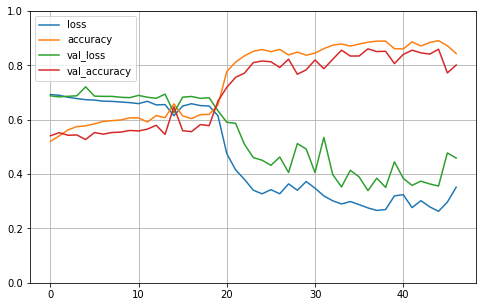

accuracy: 86.07%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 144s 369ms/step - loss: 0.6923 - accuracy: 0.5241 - val_loss: 0.6863 - val_accuracy: 0.5476


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 2/200
350/350 [==============================] - 123s 353ms/step - loss: 0.6877 - accuracy: 0.5451 - val_loss: 0.6880 - val_accuracy: 0.5385
Epoch 3/200
350/350 [==============================] - 124s 355ms/step - loss: 0.6837 - accuracy: 0.5588 - val_loss: 0.6902 - val_accuracy: 0.5383
Epoch 4/200
350/350 [==============================] - 125s 357ms/step - loss: 0.6766 - accuracy: 0.5732 - val_loss: 0.6861 - val_accuracy: 0.5514


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 5/200
350/350 [==============================] - 124s 356ms/step - loss: 0.6714 - accuracy: 0.5895 - val_loss: 0.6819 - val_accuracy: 0.5516


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 6/200
350/350 [==============================] - 125s 357ms/step - loss: 0.6718 - accuracy: 0.5865 - val_loss: 0.6916 - val_accuracy: 0.5428
Epoch 7/200
350/350 [==============================] - 124s 355ms/step - loss: 0.6680 - accuracy: 0.5980 - val_loss: 0.7038 - val_accuracy: 0.5509
Epoch 8/200
350/350 [==============================] - 124s 354ms/step - loss: 0.6666 - accuracy: 0.6020 - val_loss: 0.6814 - val_accuracy: 0.5561


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 9/200
350/350 [==============================] - 124s 353ms/step - loss: 0.6647 - accuracy: 0.5928 - val_loss: 0.6840 - val_accuracy: 0.5603


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 10/200
350/350 [==============================] - 123s 353ms/step - loss: 0.6651 - accuracy: 0.6021 - val_loss: 0.6938 - val_accuracy: 0.5596
Epoch 11/200
350/350 [==============================] - 124s 354ms/step - loss: 0.6598 - accuracy: 0.6050 - val_loss: 0.6816 - val_accuracy: 0.5592
Epoch 12/200
350/350 [==============================] - 124s 355ms/step - loss: 0.6615 - accuracy: 0.6112 - val_loss: 0.6990 - val_accuracy: 0.5463
Epoch 13/200
350/350 [==============================] - 124s 354ms/step - loss: 0.6531 - accuracy: 0.6205 - val_loss: 0.6856 - val_accuracy: 0.5623


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 14/200
350/350 [==============================] - 124s 355ms/step - loss: 0.6566 - accuracy: 0.6058 - val_loss: 0.6782 - val_accuracy: 0.5667


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 15/200
350/350 [==============================] - 124s 356ms/step - loss: 0.6531 - accuracy: 0.6205 - val_loss: 0.6771 - val_accuracy: 0.5793


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 16/200
350/350 [==============================] - 123s 353ms/step - loss: 0.6463 - accuracy: 0.6229 - val_loss: 0.6977 - val_accuracy: 0.5229
Epoch 17/200
350/350 [==============================] - 123s 352ms/step - loss: 0.6603 - accuracy: 0.6054 - val_loss: 0.7122 - val_accuracy: 0.5999


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 18/200
350/350 [==============================] - 123s 352ms/step - loss: 0.5522 - accuracy: 0.7197 - val_loss: 0.6308 - val_accuracy: 0.6518


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 19/200
350/350 [==============================] - 124s 355ms/step - loss: 0.5336 - accuracy: 0.7277 - val_loss: 0.6865 - val_accuracy: 0.5529
Epoch 20/200
350/350 [==============================] - 124s 354ms/step - loss: 0.6584 - accuracy: 0.6097 - val_loss: 0.6853 - val_accuracy: 0.5618
Epoch 21/200
350/350 [==============================] - 125s 359ms/step - loss: 0.5876 - accuracy: 0.6866 - val_loss: 0.6420 - val_accuracy: 0.6572


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 22/200
350/350 [==============================] - 125s 357ms/step - loss: 0.4937 - accuracy: 0.7630 - val_loss: 0.6331 - val_accuracy: 0.6828


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 23/200
350/350 [==============================] - 124s 355ms/step - loss: 0.4751 - accuracy: 0.7709 - val_loss: 0.5756 - val_accuracy: 0.7321


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 24/200
350/350 [==============================] - 125s 358ms/step - loss: 0.4284 - accuracy: 0.8021 - val_loss: 0.4860 - val_accuracy: 0.7779


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 25/200
350/350 [==============================] - 125s 357ms/step - loss: 0.4690 - accuracy: 0.7600 - val_loss: 0.6811 - val_accuracy: 0.5703
Epoch 26/200
350/350 [==============================] - 126s 361ms/step - loss: 0.6522 - accuracy: 0.6237 - val_loss: 0.6761 - val_accuracy: 0.5762
Epoch 27/200
350/350 [==============================] - 127s 362ms/step - loss: 0.6426 - accuracy: 0.6282 - val_loss: 0.6847 - val_accuracy: 0.5966
Epoch 28/200
350/350 [==============================] - 127s 364ms/step - loss: 0.6176 - accuracy: 0.6563 - val_loss: 0.6269 - val_accuracy: 0.6720
Epoch 29/200
350/350 [==============================] - 128s 365ms/step - loss: 0.4727 - accuracy: 0.7812 - val_loss: 0.4441 - val_accuracy: 0.7987


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 30/200
350/350 [==============================] - 128s 365ms/step - loss: 0.3973 - accuracy: 0.8205 - val_loss: 0.4956 - val_accuracy: 0.8023


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 31/200
350/350 [==============================] - 126s 361ms/step - loss: 0.3654 - accuracy: 0.8405 - val_loss: 0.4109 - val_accuracy: 0.8289


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 32/200
350/350 [==============================] - 127s 362ms/step - loss: 0.3335 - accuracy: 0.8593 - val_loss: 0.4459 - val_accuracy: 0.8210
Epoch 33/200
350/350 [==============================] - 126s 361ms/step - loss: 0.3256 - accuracy: 0.8600 - val_loss: 0.5626 - val_accuracy: 0.7379
Epoch 34/200
350/350 [==============================] - 125s 358ms/step - loss: 0.3899 - accuracy: 0.8211 - val_loss: 0.4353 - val_accuracy: 0.8244
Epoch 35/200
350/350 [==============================] - 125s 357ms/step - loss: 0.2935 - accuracy: 0.8726 - val_loss: 0.3818 - val_accuracy: 0.8453


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 36/200
350/350 [==============================] - 124s 355ms/step - loss: 0.3049 - accuracy: 0.8735 - val_loss: 0.3863 - val_accuracy: 0.8410
Epoch 37/200
350/350 [==============================] - 125s 357ms/step - loss: 0.2923 - accuracy: 0.8743 - val_loss: 0.6411 - val_accuracy: 0.6425
Epoch 38/200
350/350 [==============================] - 122s 350ms/step - loss: 0.4293 - accuracy: 0.7910 - val_loss: 0.3772 - val_accuracy: 0.8479


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 39/200
350/350 [==============================] - 126s 360ms/step - loss: 0.2816 - accuracy: 0.8817 - val_loss: 0.4812 - val_accuracy: 0.7833
Epoch 40/200
350/350 [==============================] - 122s 349ms/step - loss: 0.3481 - accuracy: 0.8434 - val_loss: 0.5596 - val_accuracy: 0.7742
Epoch 41/200
350/350 [==============================] - 121s 347ms/step - loss: 0.3122 - accuracy: 0.8638 - val_loss: 0.5250 - val_accuracy: 0.8014
Epoch 42/200
350/350 [==============================] - 122s 348ms/step - loss: 0.2958 - accuracy: 0.8741 - val_loss: 0.4429 - val_accuracy: 0.8368
Epoch 43/200
350/350 [==============================] - 129s 368ms/step - loss: 0.2823 - accuracy: 0.8799 - val_loss: 0.4011 - val_accuracy: 0.8382
Epoch 44/200
350/350 [==============================] - 131s 373ms/step - loss: 0.2518 - accuracy: 0.8994 - val_loss: 0.3784 - val_accuracy: 0.8532


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 45/200
350/350 [==============================] - 131s 376ms/step - loss: 0.2378 - accuracy: 0.8969 - val_loss: 0.3470 - val_accuracy: 0.8577


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 46/200
350/350 [==============================] - 132s 376ms/step - loss: 0.2441 - accuracy: 0.9012 - val_loss: 0.3878 - val_accuracy: 0.8586


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 47/200
350/350 [==============================] - 132s 376ms/step - loss: 0.2322 - accuracy: 0.9060 - val_loss: 0.3668 - val_accuracy: 0.8610


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 48/200
350/350 [==============================] - 132s 377ms/step - loss: 0.2339 - accuracy: 0.9073 - val_loss: 0.3451 - val_accuracy: 0.8661


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 49/200
350/350 [==============================] - 132s 377ms/step - loss: 0.2246 - accuracy: 0.9126 - val_loss: 0.3327 - val_accuracy: 0.8646
Epoch 50/200
350/350 [==============================] - 132s 376ms/step - loss: 0.2110 - accuracy: 0.9181 - val_loss: 0.3408 - val_accuracy: 0.8669


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 51/200
350/350 [==============================] - 132s 377ms/step - loss: 0.2351 - accuracy: 0.9039 - val_loss: 0.4702 - val_accuracy: 0.7843
Epoch 52/200
350/350 [==============================] - 132s 377ms/step - loss: 0.3315 - accuracy: 0.8574 - val_loss: 0.4665 - val_accuracy: 0.7895
Epoch 53/200
350/350 [==============================] - 132s 377ms/step - loss: 0.2976 - accuracy: 0.8745 - val_loss: 0.4547 - val_accuracy: 0.8069
Epoch 54/200
350/350 [==============================] - 132s 378ms/step - loss: 0.2887 - accuracy: 0.8766 - val_loss: 0.4839 - val_accuracy: 0.8074
Epoch 55/200
350/350 [==============================] - 132s 378ms/step - loss: 0.2726 - accuracy: 0.8836 - val_loss: 0.3962 - val_accuracy: 0.8354
Epoch 56/200
350/350 [==============================] - 132s 379ms/step - loss: 0.2441 - accuracy: 0.9013 - val_loss: 0.4769 - val_accuracy: 0.7853
Epoch 57/200
350/350 [==============================] - 133s 379ms/step - loss: 0.2427 - accuracy: 0.8989 - val_

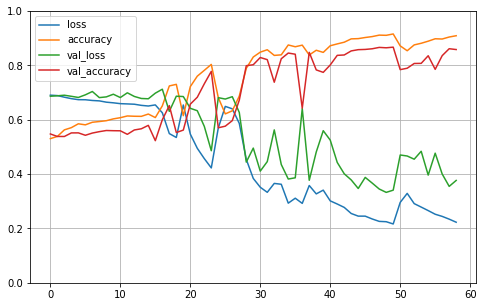

accuracy: 86.69%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 151s 387ms/step - loss: 0.6942 - accuracy: 0.5127 - val_loss: 0.6925 - val_accuracy: 0.5356


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 2/200
350/350 [==============================] - 130s 371ms/step - loss: 0.6900 - accuracy: 0.5325 - val_loss: 0.6985 - val_accuracy: 0.5360


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 3/200
350/350 [==============================] - 131s 376ms/step - loss: 0.6797 - accuracy: 0.5661 - val_loss: 0.6839 - val_accuracy: 0.5452


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 4/200
350/350 [==============================] - 131s 376ms/step - loss: 0.6812 - accuracy: 0.5663 - val_loss: 0.6941 - val_accuracy: 0.5395
Epoch 5/200
350/350 [==============================] - 132s 378ms/step - loss: 0.6726 - accuracy: 0.5873 - val_loss: 0.6887 - val_accuracy: 0.5429
Epoch 6/200
350/350 [==============================] - 132s 378ms/step - loss: 0.6719 - accuracy: 0.5876 - val_loss: 0.6834 - val_accuracy: 0.5513


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 7/200
350/350 [==============================] - 132s 377ms/step - loss: 0.6705 - accuracy: 0.5960 - val_loss: 0.6898 - val_accuracy: 0.5517


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 8/200
350/350 [==============================] - 132s 377ms/step - loss: 0.6675 - accuracy: 0.5945 - val_loss: 0.6892 - val_accuracy: 0.5522


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 9/200
350/350 [==============================] - 132s 376ms/step - loss: 0.6668 - accuracy: 0.5974 - val_loss: 0.6904 - val_accuracy: 0.5523


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 10/200
350/350 [==============================] - 134s 382ms/step - loss: 0.6608 - accuracy: 0.6066 - val_loss: 0.6791 - val_accuracy: 0.5676


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 11/200
350/350 [==============================] - 132s 378ms/step - loss: 0.6614 - accuracy: 0.6027 - val_loss: 0.6841 - val_accuracy: 0.5513
Epoch 12/200
350/350 [==============================] - 131s 376ms/step - loss: 0.6594 - accuracy: 0.5977 - val_loss: 0.7031 - val_accuracy: 0.5464
Epoch 13/200
350/350 [==============================] - 133s 380ms/step - loss: 0.6619 - accuracy: 0.6000 - val_loss: 0.7046 - val_accuracy: 0.5418
Epoch 14/200
350/350 [==============================] - 133s 380ms/step - loss: 0.6600 - accuracy: 0.6071 - val_loss: 0.7005 - val_accuracy: 0.5592
Epoch 15/200
350/350 [==============================] - 133s 381ms/step - loss: 0.6566 - accuracy: 0.6124 - val_loss: 0.6855 - val_accuracy: 0.5512
Epoch 16/200
350/350 [==============================] - 133s 382ms/step - loss: 0.6486 - accuracy: 0.6144 - val_loss: 0.6972 - val_accuracy: 0.5490
Epoch 17/200
350/350 [==============================] - 132s 378ms/step - loss: 0.6404 - accuracy: 0.6322 - val_

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 19/200
350/350 [==============================] - 133s 381ms/step - loss: 0.6310 - accuracy: 0.6460 - val_loss: 0.6719 - val_accuracy: 0.6074


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 20/200
350/350 [==============================] - 133s 380ms/step - loss: 0.5503 - accuracy: 0.7264 - val_loss: 0.6380 - val_accuracy: 0.6371


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 21/200
350/350 [==============================] - 132s 378ms/step - loss: 0.5221 - accuracy: 0.7423 - val_loss: 0.6817 - val_accuracy: 0.6639


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 22/200
350/350 [==============================] - 133s 381ms/step - loss: 0.4970 - accuracy: 0.7585 - val_loss: 0.7062 - val_accuracy: 0.6807


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 23/200
350/350 [==============================] - 132s 379ms/step - loss: 0.4651 - accuracy: 0.7806 - val_loss: 0.6661 - val_accuracy: 0.6918


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 24/200
350/350 [==============================] - 133s 379ms/step - loss: 0.4311 - accuracy: 0.8023 - val_loss: 0.5689 - val_accuracy: 0.7337


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 25/200
350/350 [==============================] - 133s 381ms/step - loss: 0.3990 - accuracy: 0.8124 - val_loss: 0.6009 - val_accuracy: 0.7195
Epoch 26/200
350/350 [==============================] - 133s 381ms/step - loss: 0.3898 - accuracy: 0.8232 - val_loss: 0.5406 - val_accuracy: 0.7490


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 27/200
350/350 [==============================] - 134s 382ms/step - loss: 0.3591 - accuracy: 0.8438 - val_loss: 0.5224 - val_accuracy: 0.7818


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 28/200
350/350 [==============================] - 134s 385ms/step - loss: 0.3480 - accuracy: 0.8497 - val_loss: 0.4920 - val_accuracy: 0.7838


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 29/200
350/350 [==============================] - 133s 380ms/step - loss: 0.3121 - accuracy: 0.8687 - val_loss: 0.4027 - val_accuracy: 0.8261


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 30/200
350/350 [==============================] - 132s 378ms/step - loss: 0.2907 - accuracy: 0.8772 - val_loss: 0.4835 - val_accuracy: 0.8023
Epoch 31/200
350/350 [==============================] - 132s 378ms/step - loss: 0.2935 - accuracy: 0.8731 - val_loss: 0.5420 - val_accuracy: 0.7640
Epoch 32/200
350/350 [==============================] - 133s 380ms/step - loss: 0.3165 - accuracy: 0.8655 - val_loss: 0.3622 - val_accuracy: 0.8696


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 33/200
350/350 [==============================] - 133s 379ms/step - loss: 0.2762 - accuracy: 0.8909 - val_loss: 0.4173 - val_accuracy: 0.8342
Epoch 34/200
350/350 [==============================] - 133s 382ms/step - loss: 0.3478 - accuracy: 0.8429 - val_loss: 0.4563 - val_accuracy: 0.7973
Epoch 35/200
350/350 [==============================] - 133s 381ms/step - loss: 0.3221 - accuracy: 0.8583 - val_loss: 0.3847 - val_accuracy: 0.8365
Epoch 36/200
350/350 [==============================] - 132s 379ms/step - loss: 0.2721 - accuracy: 0.8836 - val_loss: 0.3779 - val_accuracy: 0.8481
Epoch 37/200
350/350 [==============================] - 133s 381ms/step - loss: 0.2428 - accuracy: 0.9038 - val_loss: 0.3523 - val_accuracy: 0.8674
Epoch 38/200
350/350 [==============================] - 133s 380ms/step - loss: 0.2879 - accuracy: 0.8736 - val_loss: 0.5345 - val_accuracy: 0.7942
Epoch 39/200
350/350 [==============================] - 134s 382ms/step - loss: 0.2756 - accuracy: 0.8845 - val_

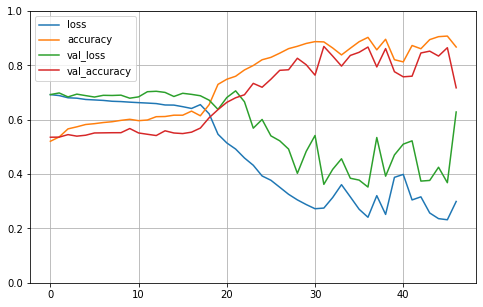

accuracy: 86.96%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 154s 390ms/step - loss: 0.6936 - accuracy: 0.5147 - val_loss: 0.6920 - val_accuracy: 0.5089


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 2/200
350/350 [==============================] - 132s 377ms/step - loss: 0.6915 - accuracy: 0.5229 - val_loss: 0.6840 - val_accuracy: 0.5546


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 3/200
350/350 [==============================] - 132s 377ms/step - loss: 0.6866 - accuracy: 0.5501 - val_loss: 0.6884 - val_accuracy: 0.5361
Epoch 4/200
350/350 [==============================] - 132s 378ms/step - loss: 0.6840 - accuracy: 0.5516 - val_loss: 0.6902 - val_accuracy: 0.5380
Epoch 5/200
350/350 [==============================] - 132s 379ms/step - loss: 0.6738 - accuracy: 0.5923 - val_loss: 0.6957 - val_accuracy: 0.5217
Epoch 6/200
350/350 [==============================] - 133s 380ms/step - loss: 0.6718 - accuracy: 0.5884 - val_loss: 0.6865 - val_accuracy: 0.5470
Epoch 7/200
350/350 [==============================] - 133s 380ms/step - loss: 0.6696 - accuracy: 0.5876 - val_loss: 0.6853 - val_accuracy: 0.5512
Epoch 8/200
350/350 [==============================] - 133s 380ms/step - loss: 0.6705 - accuracy: 0.5805 - val_loss: 0.7087 - val_accuracy: 0.5366
Epoch 9/200
350/350 [==============================] - 133s 380ms/step - loss: 0.6670 - accuracy: 0.5985 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 12/200
350/350 [==============================] - 132s 378ms/step - loss: 0.6592 - accuracy: 0.6063 - val_loss: 0.6876 - val_accuracy: 0.5590
Epoch 13/200
350/350 [==============================] - 133s 381ms/step - loss: 0.6613 - accuracy: 0.6053 - val_loss: 0.6840 - val_accuracy: 0.5588
Epoch 14/200
350/350 [==============================] - 133s 380ms/step - loss: 0.6497 - accuracy: 0.6220 - val_loss: 0.6935 - val_accuracy: 0.5572
Epoch 15/200
350/350 [==============================] - 133s 381ms/step - loss: 0.6484 - accuracy: 0.6226 - val_loss: 0.6744 - val_accuracy: 0.5790


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 16/200
350/350 [==============================] - 134s 383ms/step - loss: 0.6386 - accuracy: 0.6307 - val_loss: 0.6064 - val_accuracy: 0.6780


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 17/200
350/350 [==============================] - 134s 383ms/step - loss: 0.5094 - accuracy: 0.7462 - val_loss: 0.5707 - val_accuracy: 0.7037


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 18/200
350/350 [==============================] - 134s 383ms/step - loss: 0.4847 - accuracy: 0.7646 - val_loss: 0.6074 - val_accuracy: 0.7037
Epoch 19/200
350/350 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.7905

In [ ]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model,X_valid,y_valid)  
print ("Done")